In [49]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [50]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [51]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [52]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [53]:
tf.keras.backend.clear_session()

In [54]:
subject = 'Paraná - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [55]:
data = pd.read_csv('2003_mo_model_input_PR.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Paraná- custo m2 (R$),Paraná - IDH Renda,Paraná - Depósito Poupança (R$),Paraná - Desemprego,Paraná - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraná - IDH Longevidade,Paraná - Produção de Cimento (t),Paraná - IDH Educacao,Paraná - PIB - Estadual,Paraná - PIB - Construção Civil,Paraná - PIB - Per Capita,Paraná - PIB - Preços de Mercado,Paraná - IDH,Paraná - Consumo de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,11767.370000,0.800130,1.312029e+07,8.284196,0.300568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.819425,332.705560,0.728728,2.027147e+08,1.060612e+07,17.589536,1.851788e+08,0.776871,189.804,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,11852.421538,0.799796,1.313619e+07,8.277973,0.301710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.819770,332.945945,0.729031,2.029477e+08,1.061597e+07,17.592548,1.852326e+08,0.776975,174.713,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,11934.318946,0.799462,1.315208e+07,8.271750,0.302645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.820115,335.222130,0.729334,2.031806e+08,1.062582e+07,17.595559,1.852864e+08,0.777079,180.801,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,12015.342874,0.799128,1.316797e+07,8.265527,0.303413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.820460,334.785737,0.729638,2.034136e+08,1.063567e+07,17.598570,1.853401e+08,0.777183,180.172,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,12093.451150,0.798794,1.318386e+07,8.259304,0.304034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.820805,335.050185,0.729941,2.036466e+08,1.064551e+07,17.601581,1.853939e+08,0.777287,185.597,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,39310.840386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,39274.836083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,39220.898111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,39146.237796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


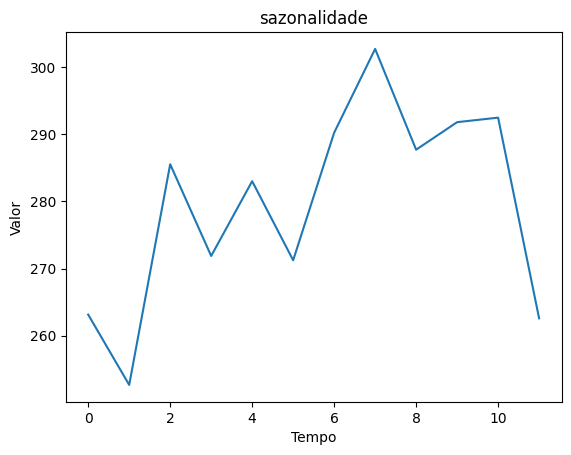

,sazonalidade
sazonalidade,
0,263.135121
1,252.658185
2,285.543932
3,271.875411
4,283.017533
5,271.230299
6,290.244238
7,302.728215
8,287.711492


In [56]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [57]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Paraná- custo m2 (R$),Paraná - IDH Renda,Paraná - Depósito Poupança (R$),Paraná - Desemprego,Paraná - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraná - IDH Longevidade,Paraná - Produção de Cimento (t),Paraná - IDH Educacao,Paraná - PIB - Estadual,Paraná - PIB - Construção Civil,Paraná - PIB - Per Capita,Paraná - PIB - Preços de Mercado,Paraná - IDH,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Paraná - Consumo de Cimento (t)
0,2003-1,11767.370000,0.800130,1.312029e+07,8.284196,0.300568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.819425,332.705560,0.728728,2.027147e+08,1.060612e+07,17.589536,1.851788e+08,0.776871,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,263.135121,189.804
1,2003-2,11852.421538,0.799796,1.313619e+07,8.277973,0.301710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.819770,332.945945,0.729031,2.029477e+08,1.061597e+07,17.592548,1.852326e+08,0.776975,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,252.658185,174.713
2,2003-3,11934.318946,0.799462,1.315208e+07,8.271750,0.302645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.820115,335.222130,0.729334,2.031806e+08,1.062582e+07,17.595559,1.852864e+08,0.777079,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,285.543932,180.801
3,2003-4,12015.342874,0.799128,1.316797e+07,8.265527,0.303413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.820460,334.785737,0.729638,2.034136e+08,1.063567e+07,17.598570,1.853401e+08,0.777183,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,271.875411,180.172
4,2003-5,12093.451150,0.798794,1.318386e+07,8.259304,0.304034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.820805,335.050185,0.729941,2.036466e+08,1.064551e+07,17.601581,1.853939e+08,0.777287,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,283.017533,185.597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,39310.840386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283.017533,NaN
245,2023-6,39274.836083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,271.230299,NaN
246,2023-7,39220.898111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,290.244238,NaN
247,2023-8,39146.237796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,302.728215,NaN


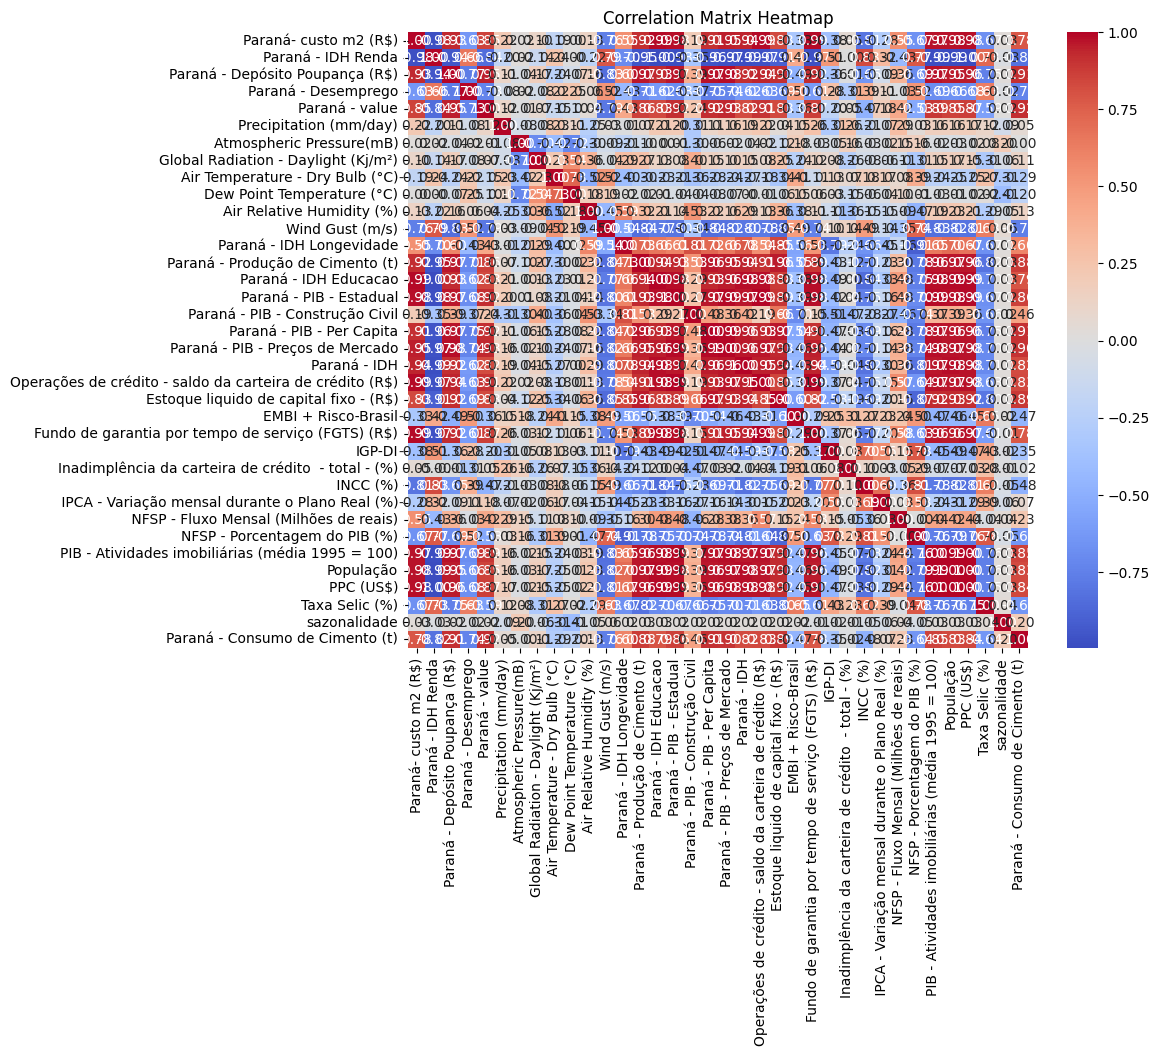

In [58]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [59]:
# data =data.drop(['Air Temperature - Dry Bulb (°C)',
#                  'Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Relative Humidity (%)'], axis=1)
# data

In [60]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
input_data = input_data.fillna(0.0)
input_data

,Paraná- custo m2 (R$),Paraná - IDH Renda,Paraná - Depósito Poupança (R$),Paraná - Desemprego,Paraná - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraná - IDH Longevidade,Paraná - Produção de Cimento (t),Paraná - IDH Educacao,Paraná - PIB - Estadual,Paraná - PIB - Construção Civil,Paraná - PIB - Per Capita,Paraná - PIB - Preços de Mercado,Paraná - IDH,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-1.527619,1.963791,-1.434643,1.200588,-0.990872,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.070988,-1.688922,-1.869571,-1.661059,-2.360392,-1.926984,-1.800632,-2.165316,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,2.723741,0.364808,4.398348,-1.873379,-2.042341,-1.825286,2.132459,-1.141385
1,-1.509891,1.937650,-1.431831,1.186349,-0.972615,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.989503,-1.684978,-1.846309,-1.644277,-2.312924,-1.907242,-1.780025,-2.131422,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,2.350880,0.368956,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-1.868315
2,-1.492820,1.911508,-1.429019,1.172110,-0.957666,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.908017,-1.647627,-1.823046,-1.627495,-2.265457,-1.887500,-1.759417,-2.097529,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,2.123016,0.331110,4.026019,-1.862949,-1.987179,-1.801637,2.999926,0.413424
3,-1.475931,1.885366,-1.426207,1.157871,-0.945388,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.826531,-1.654788,-1.799783,-1.610713,-2.217990,-1.867758,-1.738809,-2.063636,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,2.021477,0.244570,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-0.534950
4,-1.459650,1.859224,-1.423395,1.143632,-0.935451,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.745046,-1.650449,-1.776520,-1.593931,-2.170523,-1.848016,-1.718202,-2.029743,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,1.887113,0.279013,3.567576,-1.851305,-1.932017,-1.777381,2.045407,0.238133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.734355,-1.289913,1.124075,-0.826445,0.770388,-0.287994,0.549777,-0.548060,-0.817676,-0.508829,-0.038656,-0.839708,-0.543031,1.208142,1.393860,1.129314,-0.514291,0.743016,0.899324,0.733248,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,-2.010387,2.953658,-0.572934,1.406756,1.365911,1.413217,-1.311366,1.605735
188,1.755087,-1.290163,1.126665,-0.840099,0.821622,0.057496,-0.154867,0.006488,-0.259407,0.063830,-0.112274,-0.692111,-0.622641,1.241242,1.390708,1.120207,-0.507255,0.729140,0.888262,0.688083,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,-1.870713,3.351323,-0.588777,1.428132,1.376610,1.425045,-1.417143,0.563817
189,1.777184,-1.290413,1.129255,-0.853753,0.859766,0.623389,-0.348127,0.622648,0.340124,0.673559,-0.183271,-0.596494,-0.702251,1.313851,1.387556,1.111101,-0.500218,0.715264,0.877199,0.642919,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,-1.806230,3.404908,-0.612606,1.449507,1.387308,1.436067,-1.597784,0.848515
190,1.802515,-1.290664,1.131845,-0.867406,0.897253,1.015996,-0.643262,1.238096,0.799611,1.062879,-0.311174,-0.549266,-0.781861,1.363920,1.384404,1.101994,-0.493182,0.701389,0.866137,0.597754,1.370978,0.332791,-0.169867,1.654237,1

In [61]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      185.712
1      170.875
2      204.477
3      173.662
4      162.633
        ...   
244        NaN
245        NaN
246        NaN
247        NaN
248        NaN
Name: Paraná - Consumo de Cimento (t), Length: 249, dtype: float64

In [62]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Paraná- custo m2 (R$),Paraná - IDH Renda,Paraná - Depósito Poupança (R$),Paraná - Desemprego,Paraná - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraná - IDH Longevidade,Paraná - Produção de Cimento (t),Paraná - IDH Educacao,Paraná - PIB - Estadual,Paraná - PIB - Construção Civil,Paraná - PIB - Per Capita,Paraná - PIB - Preços de Mercado,Paraná - IDH,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-1.527619,1.963791,-1.434643,1.200588,-0.990872,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.070988,-1.688922,-1.869571,-1.661059,-2.360392,-1.926984,-1.800632,-2.165316,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,2.723741,0.364808,4.398348,-1.873379,-2.042341,-1.825286,2.132459,-1.141385
1,-1.509891,1.937650,-1.431831,1.186349,-0.972615,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.989503,-1.684978,-1.846309,-1.644277,-2.312924,-1.907242,-1.780025,-2.131422,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,2.350880,0.368956,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-1.868315
2,-1.492820,1.911508,-1.429019,1.172110,-0.957666,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.908017,-1.647627,-1.823046,-1.627495,-2.265457,-1.887500,-1.759417,-2.097529,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,2.123016,0.331110,4.026019,-1.862949,-1.987179,-1.801637,2.999926,0.413424
3,-1.475931,1.885366,-1.426207,1.157871,-0.945388,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.826531,-1.654788,-1.799783,-1.610713,-2.217990,-1.867758,-1.738809,-2.063636,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,2.021477,0.244570,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-0.534950
4,-1.459650,1.859224,-1.423395,1.143632,-0.935451,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.745046,-1.650449,-1.776520,-1.593931,-2.170523,-1.848016,-1.718202,-2.029743,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,1.887113,0.279013,3.567576,-1.851305,-1.932017,-1.777381,2.045407,0.238133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,1.118927,-1.331061,0.619663,0.130907,0.732054,1.883148,-0.342730,-0.119978,0.852704,1.597886,0.798804,-0.503151,1.354563,0.692024,1.379574,1.202413,-0.413954,0.937022,1.076355,1.563435,1.335787,0.819304,0.961603,1.338424,-1.233012,0.749349,-0.883659,-0.214006,1.216560,-0.607704,0.952667,1.031384,1.044043,0.043807,-1.868315
158,1.136570,-1.328690,0.639114,0.076074,0.695547,1.717848,0.407111,-0.407048,0.127298,0.650239,0.567596,-0.758668,1.303382,0.722303,1.378478,1.204670,-0.429516,0.934746,1.074731,1.542097,1.325546,0.808136,1.030624,1.300351,-1.299304,0.977327,-0.950771,-0.434717,1.155373,-0.620523,0.954843,1.042716,1.056960,0.210856,0.413424
159,1.153737,-1.326318,0.658564,0.021241,0.667742,2.005401,0.903644,-0.666709,-0.464108,-0.194246,0.259572,-0.887508,1.252200,0.729289,1.377383,1.206927,-0.445078,0.932469,1.073107,1.520760,1.315396,0.796969,1.039183,1.250508,-1.248662,1.048267,-1.028465,-0.524091,1.056140,-0.631530,0.957019,1.054049,1.070172,0.107070,-0.534950
160,1.171161,-1.323947,0.678014,-0.033592,0.634897,1.324868,1.343991,-1.200597,-1.179784,-1.021107,0.220137,-0.935408,1.201019,0.709776,1.376288,1.209183,-0.460640,0.930193,1.071484,1.499423,1.306664,0.785801,1.017171,1.240363,-1.068274,1.0488

In [63]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      185.712
1      170.875
2      204.477
3      173.662
4      162.633
        ...   
157    280.736
158    352.332
159    280.856
160    319.397
161    295.932
Name: Paraná - Consumo de Cimento (t), Length: 162, dtype: float64

In [64]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [65]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 35)

In [66]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Paraná- custo m2 (R$),Paraná - IDH Renda,Paraná - Depósito Poupança (R$),Paraná - Desemprego,Paraná - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraná - IDH Longevidade,Paraná - Produção de Cimento (t),Paraná - IDH Educacao,Paraná - PIB - Estadual,Paraná - PIB - Construção Civil,Paraná - PIB - Per Capita,Paraná - PIB - Preços de Mercado,Paraná - IDH,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
126,0.515027,-0.677534,1.259832,-1.195259,1.373912,-0.222769,1.079624,-0.658394,-1.378164,-1.851376,-0.247068,-1.249267,0.332153,0.887005,0.533340,0.826002,0.454561,0.988596,0.979507,0.670392,0.722924,0.944085,-0.882533,0.551812,-0.368821,-0.155884,0.045243,0.888984,-0.230612,-0.460555,0.913820,0.651397,0.697312,-1.048761,0.739549
127,0.537185,-0.672640,1.266115,-1.109331,1.418215,-0.203333,0.560817,-0.269676,-1.062779,-1.487772,-0.245625,-0.911880,0.303566,0.875394,0.545131,0.842968,0.424602,0.981838,0.982236,0.678142,0.745258,0.947319,-0.815413,0.566622,-0.328087,-0.349984,0.061828,0.954254,-0.156322,-0.440372,0.923198,0.664707,0.706933,-0.649312,1.605735
128,0.555420,-0.667745,1.272399,-1.023403,1.454067,-0.170890,-0.200468,0.256715,-0.570413,-0.856435,-0.179589,-0.788932,0.274980,0.855534,0.556922,0.859935,0.394643,0.975081,0.984964,0.685892,0.767990,0.950553,-0.745839,0.568617,-0.176031,-0.529294,0.046225,1.045217,-0.120008,-0.419247,0.932576,0.678017,0.715675,-0.535369,0.563817
129,0.572914,-0.662851,1.278682,-0.937476,1.490026,0.159122,-0.623322,1.217175,0.063145,-0.160407,-0.220686,-0.631550,0.246393,0.842489,0.568712,0.876901,0.364683,0.968323,0.987693,0.693642,0.799035,0.953786,-0.687348,0.719776,-0.113037,-0.788101,0.032522,1.176395,-0.143194,-0.397019,0.941953,0.691327,0.723490,-1.288807,0.848515
130,0.590350,-0.657957,1.284966,-0.851548,1.513267,-0.027260,-0.984130,1.592569,0.663885,0.477898,-0.244957,-0.707205,0.217807,0.820774,0.580503,0.893867,0.334724,0.961566,0.990422,0.701392,0.830824,0.957020,-0.639220,0.905478,-0.022703,-1.020394,0.042757,1.303259,-0.028712,-0.376532,0.942711,0.704637,0.730579,-1.507550,0.895147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.734355,-1.289913,1.124075,-0.826445,0.770388,-0.287994,0.549777,-0.548060,-0.817676,-0.508829,-0.038656,-0.839708,-0.543031,1.208142,1.393860,1.129314,-0.514291,0.743016,0.899324,0.733248,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,-2.010387,2.953658,-0.572934,1.406756,1.365911,1.413217,-1.311366,1.605735
188,1.755087,-1.290163,1.126665,-0.840099,0.821622,0.057496,-0.154867,0.006488,-0.259407,0.063830,-0.112274,-0.692111,-0.622641,1.241242,1.390708,1.120207,-0.507255,0.729140,0.888262,0.688083,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,-1.870713,3.351323,-0.588777,1.428132,1.376610,1.425045,-1.417143,0.563817
189,1.777184,-1.290413,1.129255,-0.853753,0.859766,0.623389,-0.348127,0.622648,0.340124,0.673559,-0.183271,-0.596494,-0.702251,1.313851,1.387556,1.111101,-0.500218,0.715264,0.877199,0.642919,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,-1.806230,3.404908,-0.612606,1.449507,1.387308,1.436067,-1.597784,0.848515
190,1.802515,-1.290664,1.131845,-0.867406,0.897253,1.015996,-0.643262,1.238096,0.799611,1.062879,-0.311174,-0.549266,-0.781861,1.363920,1.384404,1.101994,-0.493182,0.701389,0.866137,0.597754,1.370978,0.332791,-0.169867,1.654237,1.815728,-1.02068

In [67]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 35)

In [68]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [69]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    train, train_val = validation_splitter(train_input, 7)
    target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                             return_sequences=True, 
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(180,activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train, 
                        target, 
                        epochs=10000,
                        validation_data=(train_val,
                                         target_val),
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [70]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(50)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [71]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[2647896311, 3513318871, 1886328957, 3492672563, 2827617047, 4006114263, 2277393924, 3760722588, 220418066, 2938344470, 1595222226, 772586311, 2229454383, 1207190097, 3986389066, 1226069712, 2451039201, 1605442973, 1795320447, 3899892610, 4111911676, 1775279313, 1499025156, 3036398474, 1243220944, 1234823394, 599162139, 3164830379, 1198518262, 278147751, 113974479, 94114959, 3159591573, 2722732344, 53254780, 2310874981, 1867288397, 1580242319, 394283014, 3881423950, 3870346532, 2397413731, 2315582672, 3339893283, 3675434111, 21129765, 4112268349, 4120461072, 2999882844, 2099860418]


Step: 0 ___________________________________________
val_loss: 113.80372619628906
winner_seed: 2647896311


Step: 1 ___________________________________________
val_loss: 126.60267639160156


Step: 2 ___________________________________________
val_loss: 140.0159454345703


Step: 3 ___________________________________________
val_loss: 301.6572265625


Step: 4 ___________________________________________
val_lo

In [72]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 124ms/step - loss: 72719.0938 - val_loss: 3421.2290
Epoch 2/10000
4/4 [==============================] - 0s 10ms/step - loss: 4374.4229 - val_loss: 3695.9521
Epoch 3/10000
4/4 [==============================] - 0s 9ms/step - loss: 4325.3677 - val_loss: 3466.8616
Epoch 4/10000
4/4 [==============================] - 0s 9ms/step - loss: 4820.2510 - val_loss: 3970.9658
Epoch 5/10000
4/4 [==============================] - 0s 9ms/step - loss: 4576.5371 - val_loss: 3436.3914
Epoch 6/10000
4/4 [==============================] - 0s 9ms/step - loss: 4818.7910 - val_loss: 3727.4922
Epoch 7/10000
4/4 [==============================] - 0s 9ms/step - loss: 4294.6904 - val_loss: 3421.0591
Epoch 8/10000
4/4 [==============================] - 0s 9ms/step - loss: 4157.7505 - val_loss: 3245.3892
Epoch 9/10000
4/4 [==============================] - 0s 9ms/step - loss: 4191.3057 - val_loss: 3217.5801
Epoch 10/10000
4/4 [==============================]

4/4 [==============================] - 0s 11ms/step - loss: 639.5249 - val_loss: 550.5128
Epoch 79/10000
4/4 [==============================] - 0s 9ms/step - loss: 554.4799 - val_loss: 449.4194
Epoch 80/10000
4/4 [==============================] - 0s 9ms/step - loss: 535.5186 - val_loss: 528.0840
Epoch 81/10000
4/4 [==============================] - 0s 9ms/step - loss: 575.8433 - val_loss: 454.6104
Epoch 82/10000
4/4 [==============================] - 0s 9ms/step - loss: 597.7224 - val_loss: 541.6765
Epoch 83/10000
4/4 [==============================] - 0s 8ms/step - loss: 542.2810 - val_loss: 498.4224
Epoch 84/10000
4/4 [==============================] - 0s 8ms/step - loss: 541.6141 - val_loss: 530.3666
Epoch 85/10000
4/4 [==============================] - 0s 9ms/step - loss: 512.3378 - val_loss: 666.4876
Epoch 86/10000
4/4 [==============================] - 0s 10ms/step - loss: 633.0068 - val_loss: 529.0212
Epoch 87/10000
4/4 [==============================] - 0s 10ms/step - loss: 49

4/4 [==============================] - 0s 10ms/step - loss: 337.6405 - val_loss: 415.1257
Epoch 157/10000
4/4 [==============================] - 0s 10ms/step - loss: 411.6203 - val_loss: 332.5672
Epoch 158/10000
4/4 [==============================] - 0s 10ms/step - loss: 383.5699 - val_loss: 314.8032
Epoch 159/10000
4/4 [==============================] - 0s 10ms/step - loss: 410.1641 - val_loss: 259.8445
Epoch 160/10000
4/4 [==============================] - 0s 10ms/step - loss: 318.9929 - val_loss: 254.2063
Epoch 161/10000
4/4 [==============================] - 0s 8ms/step - loss: 408.8631 - val_loss: 406.3608
Epoch 162/10000
4/4 [==============================] - 0s 9ms/step - loss: 524.1690 - val_loss: 411.5879
Epoch 163/10000
4/4 [==============================] - 0s 9ms/step - loss: 433.3846 - val_loss: 426.0428
Epoch 164/10000
4/4 [==============================] - 0s 8ms/step - loss: 455.6067 - val_loss: 229.3996
Epoch 165/10000
4/4 [==============================] - 0s 8ms/step

Epoch 234/10000
4/4 [==============================] - 0s 9ms/step - loss: 240.5545 - val_loss: 284.9443
Epoch 235/10000
4/4 [==============================] - 0s 9ms/step - loss: 418.7059 - val_loss: 371.0734
Epoch 236/10000
4/4 [==============================] - 0s 10ms/step - loss: 511.2361 - val_loss: 365.8830
Epoch 237/10000
4/4 [==============================] - 0s 9ms/step - loss: 269.6596 - val_loss: 299.7079
Epoch 238/10000
4/4 [==============================] - 0s 9ms/step - loss: 233.4240 - val_loss: 288.0276
Epoch 239/10000
4/4 [==============================] - 0s 9ms/step - loss: 228.3924 - val_loss: 306.3293
Epoch 240/10000
4/4 [==============================] - 0s 10ms/step - loss: 266.6981 - val_loss: 268.7857
Epoch 241/10000
4/4 [==============================] - 0s 10ms/step - loss: 229.7731 - val_loss: 230.0104
Epoch 242/10000
4/4 [==============================] - 0s 9ms/step - loss: 233.5332 - val_loss: 280.0341
Epoch 243/10000
4/4 [==============================]

4/4 [==============================] - 0s 9ms/step - loss: 199.2476 - val_loss: 362.0823
Epoch 312/10000
4/4 [==============================] - 0s 10ms/step - loss: 203.0011 - val_loss: 264.8460
Epoch 313/10000
4/4 [==============================] - 0s 9ms/step - loss: 190.9254 - val_loss: 220.0777
Epoch 314/10000
4/4 [==============================] - 0s 8ms/step - loss: 220.0318 - val_loss: 273.4526
Epoch 315/10000
4/4 [==============================] - 0s 8ms/step - loss: 193.5840 - val_loss: 205.7924
Epoch 316/10000
4/4 [==============================] - 0s 9ms/step - loss: 299.8025 - val_loss: 212.4140
Epoch 317/10000
4/4 [==============================] - 0s 9ms/step - loss: 227.5898 - val_loss: 191.8915
Epoch 318/10000
4/4 [==============================] - 0s 10ms/step - loss: 165.5992 - val_loss: 179.9769
Epoch 319/10000
4/4 [==============================] - 0s 10ms/step - loss: 169.5572 - val_loss: 277.9674
Epoch 320/10000
4/4 [==============================] - 0s 10ms/step 

Epoch 389/10000
4/4 [==============================] - 0s 8ms/step - loss: 194.5964 - val_loss: 380.4728
Epoch 390/10000
4/4 [==============================] - 0s 9ms/step - loss: 245.3732 - val_loss: 259.8759
Epoch 391/10000
4/4 [==============================] - 0s 8ms/step - loss: 152.4157 - val_loss: 213.5383
Epoch 392/10000
4/4 [==============================] - 0s 9ms/step - loss: 149.1559 - val_loss: 218.8546
Epoch 393/10000
4/4 [==============================] - 0s 9ms/step - loss: 140.5485 - val_loss: 237.3578
Epoch 394/10000
4/4 [==============================] - 0s 9ms/step - loss: 137.6541 - val_loss: 234.3541
Epoch 395/10000
4/4 [==============================] - 0s 9ms/step - loss: 178.8568 - val_loss: 237.5072
Epoch 396/10000
4/4 [==============================] - 0s 9ms/step - loss: 168.2909 - val_loss: 235.5776
Epoch 397/10000
4/4 [==============================] - 0s 11ms/step - loss: 165.4721 - val_loss: 214.1804
Epoch 398/10000
4/4 [==============================] -

Epoch 467/10000
4/4 [==============================] - 0s 9ms/step - loss: 124.1407 - val_loss: 257.3004
Epoch 468/10000
4/4 [==============================] - 0s 8ms/step - loss: 148.0809 - val_loss: 288.7159
Epoch 469/10000
4/4 [==============================] - 0s 8ms/step - loss: 125.6740 - val_loss: 245.9928
Epoch 470/10000
4/4 [==============================] - 0s 8ms/step - loss: 150.3674 - val_loss: 272.7882
Epoch 471/10000
4/4 [==============================] - 0s 8ms/step - loss: 130.9249 - val_loss: 265.3895
Epoch 472/10000
4/4 [==============================] - 0s 9ms/step - loss: 134.9226 - val_loss: 236.5754
Epoch 473/10000
4/4 [==============================] - 0s 8ms/step - loss: 156.4156 - val_loss: 361.1264
Epoch 474/10000
4/4 [==============================] - 0s 8ms/step - loss: 172.6685 - val_loss: 284.5348
Epoch 475/10000
4/4 [==============================] - 0s 9ms/step - loss: 140.5200 - val_loss: 247.4794
Epoch 476/10000
4/4 [==============================] - 

4/4 [==============================] - 0s 10ms/step - loss: 88.0275 - val_loss: 213.2628
Epoch 546/10000
4/4 [==============================] - 0s 9ms/step - loss: 95.6691 - val_loss: 226.9764
Epoch 547/10000
4/4 [==============================] - 0s 9ms/step - loss: 86.3817 - val_loss: 217.0370
Epoch 548/10000
4/4 [==============================] - 0s 9ms/step - loss: 108.9548 - val_loss: 193.6187
Epoch 549/10000
4/4 [==============================] - 0s 10ms/step - loss: 87.5700 - val_loss: 167.0699
Epoch 550/10000
4/4 [==============================] - 0s 10ms/step - loss: 91.8922 - val_loss: 160.7420
Epoch 551/10000
4/4 [==============================] - 0s 10ms/step - loss: 91.3935 - val_loss: 178.8094
Epoch 552/10000
4/4 [==============================] - 0s 10ms/step - loss: 87.5064 - val_loss: 160.0033
Epoch 553/10000
4/4 [==============================] - 0s 10ms/step - loss: 93.8985 - val_loss: 218.2138
Epoch 554/10000
4/4 [==============================] - 0s 9ms/step - loss

4/4 [==============================] - 0s 9ms/step - loss: 72.5894 - val_loss: 252.2078
Epoch 624/10000
4/4 [==============================] - 0s 8ms/step - loss: 79.4610 - val_loss: 241.3784
Epoch 625/10000
4/4 [==============================] - 0s 8ms/step - loss: 99.2621 - val_loss: 281.5297
Epoch 626/10000
4/4 [==============================] - 0s 8ms/step - loss: 104.5189 - val_loss: 299.0228
Epoch 627/10000
4/4 [==============================] - 0s 9ms/step - loss: 86.9883 - val_loss: 171.5004
Epoch 628/10000
4/4 [==============================] - 0s 8ms/step - loss: 64.3437 - val_loss: 170.4797
Epoch 629/10000
4/4 [==============================] - 0s 8ms/step - loss: 84.3193 - val_loss: 227.9937
Epoch 630/10000
4/4 [==============================] - 0s 9ms/step - loss: 107.8397 - val_loss: 247.0801
Epoch 631/10000
4/4 [==============================] - 0s 8ms/step - loss: 84.9037 - val_loss: 191.3724
Epoch 632/10000
4/4 [==============================] - 0s 9ms/step - loss: 93.

4/4 [==============================] - 0s 10ms/step - loss: 86.1224 - val_loss: 190.4299
Epoch 702/10000
4/4 [==============================] - 0s 9ms/step - loss: 61.1858 - val_loss: 174.3479
Epoch 703/10000
4/4 [==============================] - 0s 10ms/step - loss: 89.0818 - val_loss: 199.3680
Epoch 704/10000
4/4 [==============================] - 0s 10ms/step - loss: 142.8932 - val_loss: 221.4789
Epoch 705/10000
4/4 [==============================] - 0s 12ms/step - loss: 72.9596 - val_loss: 221.3485
Epoch 706/10000
4/4 [==============================] - 0s 10ms/step - loss: 83.5209 - val_loss: 162.6177
Epoch 707/10000
4/4 [==============================] - 0s 9ms/step - loss: 62.0142 - val_loss: 170.2609
Epoch 708/10000
4/4 [==============================] - 0s 8ms/step - loss: 68.3317 - val_loss: 185.8335
Epoch 709/10000
4/4 [==============================] - 0s 9ms/step - loss: 64.7823 - val_loss: 219.2902
Epoch 710/10000
4/4 [==============================] - 0s 9ms/step - loss:

4/4 [==============================] - 0s 9ms/step - loss: 68.9025 - val_loss: 206.8001
Epoch 780/10000
4/4 [==============================] - 0s 9ms/step - loss: 50.2869 - val_loss: 212.5472
Epoch 781/10000
4/4 [==============================] - 0s 9ms/step - loss: 70.3284 - val_loss: 226.1272
Epoch 782/10000
4/4 [==============================] - 0s 9ms/step - loss: 49.6428 - val_loss: 173.2197
Epoch 783/10000
4/4 [==============================] - 0s 9ms/step - loss: 59.9489 - val_loss: 197.0236
Epoch 784/10000
4/4 [==============================] - 0s 10ms/step - loss: 63.9720 - val_loss: 221.6675
Epoch 785/10000
4/4 [==============================] - 0s 8ms/step - loss: 61.8744 - val_loss: 186.2941
Epoch 786/10000
4/4 [==============================] - 0s 9ms/step - loss: 49.5923 - val_loss: 224.5932
Epoch 787/10000
4/4 [==============================] - 0s 9ms/step - loss: 71.2414 - val_loss: 186.2769
Epoch 788/10000
4/4 [==============================] - 0s 9ms/step - loss: 80.3

4/4 [==============================] - 0s 9ms/step - loss: 61.1763 - val_loss: 164.8528
Epoch 858/10000
4/4 [==============================] - 0s 9ms/step - loss: 47.8255 - val_loss: 183.0574
Epoch 859/10000
4/4 [==============================] - 0s 9ms/step - loss: 40.8835 - val_loss: 175.0385
Epoch 860/10000
4/4 [==============================] - 0s 9ms/step - loss: 51.1843 - val_loss: 148.9358
Epoch 861/10000
4/4 [==============================] - 0s 9ms/step - loss: 62.1877 - val_loss: 163.7000
Epoch 862/10000
4/4 [==============================] - 0s 9ms/step - loss: 58.9811 - val_loss: 194.0896
Epoch 863/10000
4/4 [==============================] - 0s 9ms/step - loss: 51.6489 - val_loss: 197.3391
Epoch 864/10000
4/4 [==============================] - 0s 9ms/step - loss: 81.2169 - val_loss: 194.2409
Epoch 865/10000
4/4 [==============================] - 0s 9ms/step - loss: 66.7515 - val_loss: 275.4314
Epoch 866/10000
4/4 [==============================] - 0s 8ms/step - loss: 72.25

4/4 [==============================] - 0s 9ms/step - loss: 50.8026 - val_loss: 252.6299
Epoch 936/10000
4/4 [==============================] - 0s 9ms/step - loss: 75.7164 - val_loss: 207.9300
Epoch 937/10000
4/4 [==============================] - 0s 9ms/step - loss: 46.4591 - val_loss: 180.5353
Epoch 938/10000
4/4 [==============================] - 0s 9ms/step - loss: 47.1734 - val_loss: 217.7985
Epoch 939/10000
4/4 [==============================] - 0s 10ms/step - loss: 44.9647 - val_loss: 271.2134
Epoch 940/10000
4/4 [==============================] - 0s 10ms/step - loss: 61.9981 - val_loss: 216.1639
Epoch 941/10000
4/4 [==============================] - 0s 9ms/step - loss: 65.0684 - val_loss: 173.4509
Epoch 942/10000
4/4 [==============================] - 0s 10ms/step - loss: 47.0875 - val_loss: 223.7529
Epoch 943/10000
4/4 [==============================] - 0s 9ms/step - loss: 41.2849 - val_loss: 262.5477
Epoch 944/10000
4/4 [==============================] - 0s 10ms/step - loss: 5

4/4 [==============================] - 0s 8ms/step - loss: 47.3145 - val_loss: 190.6482
Epoch 1014/10000
4/4 [==============================] - 0s 8ms/step - loss: 102.2260 - val_loss: 227.3866
Epoch 1015/10000
4/4 [==============================] - 0s 9ms/step - loss: 51.1080 - val_loss: 241.4059
Epoch 1016/10000
4/4 [==============================] - 0s 9ms/step - loss: 54.2573 - val_loss: 224.3692
Epoch 1017/10000
4/4 [==============================] - 0s 9ms/step - loss: 44.8605 - val_loss: 177.7896
Epoch 1018/10000
4/4 [==============================] - 0s 10ms/step - loss: 62.9672 - val_loss: 182.0581
Epoch 1019/10000
4/4 [==============================] - 0s 10ms/step - loss: 54.7798 - val_loss: 193.0112
Epoch 1020/10000
4/4 [==============================] - 0s 9ms/step - loss: 51.7273 - val_loss: 261.0909
Epoch 1021/10000
4/4 [==============================] - 0s 11ms/step - loss: 39.6292 - val_loss: 232.7093
Epoch 1022/10000
4/4 [==============================] - 0s 9ms/step 

Epoch 1091/10000
4/4 [==============================] - 0s 8ms/step - loss: 54.8198 - val_loss: 192.0613
Epoch 1092/10000
4/4 [==============================] - 0s 9ms/step - loss: 56.5405 - val_loss: 200.8458
Epoch 1093/10000
4/4 [==============================] - 0s 9ms/step - loss: 40.5519 - val_loss: 301.9413
Epoch 1094/10000
4/4 [==============================] - 0s 8ms/step - loss: 51.2543 - val_loss: 260.8500
Epoch 1095/10000
4/4 [==============================] - 0s 9ms/step - loss: 43.8733 - val_loss: 246.8375
Epoch 1096/10000
4/4 [==============================] - 0s 9ms/step - loss: 50.4683 - val_loss: 221.9567
Epoch 1097/10000
4/4 [==============================] - 0s 10ms/step - loss: 39.2186 - val_loss: 212.0047
Epoch 1098/10000
4/4 [==============================] - 0s 9ms/step - loss: 42.2627 - val_loss: 213.6823
Epoch 1099/10000
4/4 [==============================] - 0s 9ms/step - loss: 50.3090 - val_loss: 299.7987
Epoch 1100/10000
4/4 [==============================] 

Epoch 1169/10000
4/4 [==============================] - 0s 9ms/step - loss: 41.9306 - val_loss: 286.7466
Epoch 1170/10000
4/4 [==============================] - 0s 9ms/step - loss: 58.3200 - val_loss: 251.2028
Epoch 1171/10000
4/4 [==============================] - 0s 9ms/step - loss: 68.4066 - val_loss: 244.3939
Epoch 1172/10000
4/4 [==============================] - 0s 9ms/step - loss: 32.2376 - val_loss: 263.4046
Epoch 1173/10000
4/4 [==============================] - 0s 9ms/step - loss: 35.3919 - val_loss: 236.2762
Epoch 1174/10000
4/4 [==============================] - 0s 8ms/step - loss: 38.7244 - val_loss: 265.1851
Epoch 1175/10000
4/4 [==============================] - 0s 8ms/step - loss: 39.9451 - val_loss: 242.6801
Epoch 1176/10000
4/4 [==============================] - 0s 9ms/step - loss: 27.2785 - val_loss: 223.2399
Epoch 1177/10000
4/4 [==============================] - 0s 9ms/step - loss: 50.9160 - val_loss: 239.9721
Epoch 1178/10000
4/4 [==============================] -

Epoch 1247/10000
4/4 [==============================] - 0s 10ms/step - loss: 53.4913 - val_loss: 245.1308
Epoch 1248/10000
4/4 [==============================] - 0s 9ms/step - loss: 33.3495 - val_loss: 269.1489
Epoch 1249/10000
4/4 [==============================] - 0s 9ms/step - loss: 37.1227 - val_loss: 287.4074
Epoch 1250/10000
4/4 [==============================] - 0s 9ms/step - loss: 63.3644 - val_loss: 298.6595
Epoch 1251/10000
4/4 [==============================] - 0s 10ms/step - loss: 38.8718 - val_loss: 249.8199
Epoch 1252/10000
4/4 [==============================] - 0s 10ms/step - loss: 81.0726 - val_loss: 238.9358
Epoch 1253/10000
4/4 [==============================] - 0s 10ms/step - loss: 50.3004 - val_loss: 261.9945
Epoch 1254/10000
4/4 [==============================] - 0s 11ms/step - loss: 45.3528 - val_loss: 247.8125
Epoch 1255/10000
4/4 [==============================] - 0s 9ms/step - loss: 35.0662 - val_loss: 255.2439
Epoch 1256/10000
4/4 [============================

Epoch 1325/10000
4/4 [==============================] - 0s 8ms/step - loss: 45.2711 - val_loss: 271.5800
Epoch 1326/10000
4/4 [==============================] - 0s 10ms/step - loss: 44.1112 - val_loss: 269.3179
Epoch 1327/10000
4/4 [==============================] - 0s 8ms/step - loss: 67.3798 - val_loss: 242.1771
Epoch 1328/10000
4/4 [==============================] - 0s 9ms/step - loss: 49.1887 - val_loss: 274.5225
Epoch 1329/10000
4/4 [==============================] - 0s 9ms/step - loss: 33.5600 - val_loss: 260.2603
Epoch 1330/10000
4/4 [==============================] - 0s 9ms/step - loss: 51.6277 - val_loss: 321.5001
Epoch 1331/10000
4/4 [==============================] - 0s 8ms/step - loss: 35.0607 - val_loss: 277.1064
Epoch 1332/10000
4/4 [==============================] - 0s 8ms/step - loss: 34.9406 - val_loss: 258.5355
Epoch 1333/10000
4/4 [==============================] - 0s 9ms/step - loss: 41.0971 - val_loss: 266.2466
Epoch 1334/10000
4/4 [==============================] 

In [73]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [74]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,342.738403,355.837463,353.294342,350.248871,345.359161,318.600281,329.033844,296.793182,350.584259,285.183655,304.409393,304.989227,332.678192,355.171234,362.203003,346.986481,343.571106,330.367523,336.313934,316.745361,341.790314,303.329803,311.121277,305.857697,328.456268,340.812592,323.086365,330.653625,347.604034,307.745209
Target,354.558,360.106,350.123,288.254,301.687,268.901,274.431,298.219,328.955,335.039,260.723,366.929,353.426,344.937,302.082,294.467,336.029,278.117,323.005,291.453,300.203,317.058,314.142,301.878,358.797,356.169,316.188,346.214,323.401,238.466
Error,11.819611,4.268524,3.171356,61.994873,43.67215,49.69928,54.602844,1.425812,21.629272,49.855347,43.686401,61.939758,20.747803,10.234222,60.121002,52.51947,7.542114,52.250519,13.308929,25.292358,41.587311,13.72821,3.020721,3.979706,30.340729,15.356415,6.898376,15.560364,24.203033,69.279205


In [75]:
display(mae)
display(mape)

29.124523

0.09740165

In [76]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input.iloc[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [77]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             test_input, 
                                             test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

NameError: name 'test_target' is not defined